# Training a multi-task regression model for neural crest cells

In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata

## Set experiment parameters

In [46]:
experiment = 'multi_task_1'
if not os.path.exists(experiment):
    os.makedirs(experiment)
    
genome = 'danRer11' #"GRCz11"
seq_len = 500 # Length of the input sequence

## Load Data

In [47]:
peaks = pd.read_csv("../data/normalized_peaks.csv")

ad = peaks.to_numpy()
ad = anndata.AnnData(ad).T

# Prepare ad.obs
cell_types = pd.DataFrame({'cell type': peaks.columns})
ad.obs = cell_types
ad.obs_names = ad.obs['cell type']

# Prepare ad.var
var = pd.read_csv("../data/chromosomes.10hpf.bed", sep = '\t', header = None)
var.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
var = var.drop(columns =['name', 'score', 'strand'])
var.index = var.index.astype(str)
ad.var = var

ad.shape

(15, 370058)

In [48]:
ad.obs

,cell type
cell type,
anterior/posterior axis,anterior/posterior axis
central nervous system,central nervous system
forebrain,forebrain
immature eye,immature eye
integument,integument
lateral plate mesoderm,lateral plate mesoderm
mesenchyme cell,mesenchyme cell
musculature system,musculature system
neural crest,neural crest


In [49]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

In [50]:
ad.var.head()

,chrom,start,end
0,chr1,5231,5732
1,chr1,5786,6287
2,chr1,10087,10588
3,chr1,10990,11491
4,chr1,11894,12395


In [51]:
ad.X[0:5,0:5]

array([[4.65111754, 4.7597768 , 4.84433467, 4.91311991, 5.09123001],
       [4.53367234, 4.71507734, 4.6939733 , 4.97038916, 5.15560569],
       [3.74337616, 3.89092058, 3.71531718, 4.50199984, 4.58080749],
       [4.67651185, 4.80295157, 4.32103392, 4.53860808, 4.89682671],
       [3.88919404, 3.75913911, 3.88919404, 4.40643606, 4.7314921 ]])

## Select small dataset for testing

In [52]:
#ad = ad[:,:50000]
ad.shape

(15, 370058)

## Filter peaks

Performing filtering of the dataset using `grelu.data.preprocess` module.

First, we filter peaks within autosomes (chromosomes 1 - 22) or chromosomes X/Y.

In [53]:
import grelu.data.preprocess

ad = grelu.data.preprocess.filter_chromosomes(ad, 'autosomes')

Keeping 333823 intervals


## Resize peaks

ATAC-seq peaks can take different lengths. Hence, we resize all ATAC-seq peaks to a constant sequence length of 200 bp to train the model as follows:

In [54]:
import grelu.sequence.utils


ad.var = grelu.sequence.utils.resize(ad.var, seq_len)
ad.var.head(3)

,chrom,start,end
0,chr1,5232,5732
1,chr1,5787,6287
2,chr1,10088,10588


## Split data

In [55]:
ad.var['chrom'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

In [56]:
train_chroms='autosomes'
val_chroms=['chr3']
test_chroms=['chr4']


ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad, 
    train_chroms = train_chroms, val_chroms = val_chroms, 
    test_chroms = test_chroms,
)

Selecting training samples
Keeping 303354 intervals


Selecting validation samples
Keeping 17079 intervals


Selecting test samples
Keeping 13390 intervals
Final sizes: train: (15, 303354), val: (15, 17079), test: (15, 13390)


## Make labeled sequence datasets

In [57]:
import grelu.data.dataset

In [58]:
train_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_train.copy(),
    genome = genome,
    rc = True, #reverse complement
    max_seq_shift = 1, # Shift the sequence
    augment_mode = "random", # Randomly select which augmentations to apply
)

In [59]:
val_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_val.copy(), genome=genome)
test_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_test.copy(), genome=genome)

## Build model

Here we use the DiltatedConvModel

In [60]:
model_params = {
    'model_type':'DilatedConvModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, # No cropping of the model output. What does this really mean?
    'channels':512,
    'n_conv':8,
}

train_params = {
    'task':'regression', # regression
    'loss': 'mse', 
    'lr': 1e-4, # learning rate
    'logger': 'csv', # Logs will be written to a CSV file
    'batch_size':512,
    'max_epochs':10,
    'devices':0, # Either “cpu” or an integer or list of integers representing the indices of the GPUs for training
    'num_workers':8,
    'optimizer': 'adam',
    'save_dir':experiment,
    'checkpoint': True, # Save checkpoints
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params, train_params)

In [61]:
print(model)

LightningModel(
  (model): DilatedConvModel(
    (embedding): DilatedConvTrunk(
      (conv_tower): ConvTower(
        (blocks): ModuleList(
          (0): Stem(
            (conv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=same)
            (act): Activation(
              (layer): ReLU()
            )
            (pool): Pool(
              (layer): Identity()
            )
          )
          (1): ConvBlock(
            (norm): Norm(
              (layer): Identity()
            )
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
            (act): Activation(
              (layer): ReLU()
            )
            (pool): Pool(
              (layer): Identity()
            )
            (dropout): Dropout(
              (layer): Identity()
            )
            (channel_transform): ChannelTransform(
              (layer): Identity()
            )
          )
          (2): ConvBlock(
            (norm): Norm(
       

## Train model

In [62]:
# See the 'single_task_1' folder for logs
trainer = model.train_on_dataset(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 34/34 [00:03<00:00,  8.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             7.611850738525391
         val_mse             7.537647724151611
       val_pearson                  nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | DilatedConvModel | 5.6 M  | train
1 | loss         | MSELoss          | 0      | train
2 | activation   | Identity         | 0      | train
3 | val_metrics  | MetricCollection | 0      | train
4 | test_metrics | MetricCollection | 0      | train
5 | transform    | Identity         | 0      | train
----------------------------------------------------------
5.6 M     Trainable params
0         Non-trai

/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.


Epoch 9: 100%|██████████| 593/593 [03:21<00:00,  2.94it/s, v_num=0, train_loss_step=0.877, train_loss_epoch=0.914]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 593/593 [03:22<00:00,  2.93it/s, v_num=0, train_loss_step=0.877, train_loss_epoch=0.914]


## Load best model from checkpoint

In [63]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

multi_task_1/2025_22_04_15_23/version_0/checkpoints/epoch=8-step=5337.ckpt


## Evaluate model on the test set

In [64]:
test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=256,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1922259330749512
        test_mse            1.1961851119995117
      test_pearson          0.39259907603263855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Run inference on held out sequences

In [65]:
preds = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8
    )
preds.shape

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.60it/s]


(13390, 15, 1)

In [66]:
preds_df = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8,
    return_df=True # Return the output as a pandas dataframe
    )
preds_df.head()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.60it/s]


,anterior/posterior axis,central nervous system,forebrain,immature eye,integument,lateral plate mesoderm,mesenchyme cell,musculature system,neural crest,neural keel,neural stem cell,periderm/epidermis,primary neuron,segmental plate,YSL
0,2.337866,2.337668,2.325721,2.303970,2.353209,2.307984,2.351334,2.296268,2.306596,2.334677,2.376333,2.378273,2.503592,2.337805,2.638943
1,2.036268,2.064192,1.916051,1.963705,2.112835,2.002689,2.047206,2.133738,2.041545,2.044926,1.985669,2.196030,2.055788,2.091377,2.233588
2,1.853532,1.832697,1.698206,1.717730,1.978094,1.848101,1.898735,2.008554,1.886568,1.838950,1.734470,2.091789,1.882006,1.933719,2.392678
3,2.782738,2.744865,2.751081,2.821944,2.967991,2.883208,3.073868,2.803445,2.858552,2.923788,3.009912,2.809453,3.043293,2.857049,2.676149
4,2.619051,2.807729,2.652213,2.633376,2.539722,2.647430,2.727164,2.559699,2.654858,2.764772,2.723114,2.405354,2.754776,2.639422,2.158624


In [78]:
import grelu.visualize

In [79]:
'''
grelu.visualize.plot_pred_scatter(
    preds=preds,
    labels=test_dataset.get_labels(),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)
'''

'\ngrelu.visualize.plot_pred_scatter(\n    preds=preds,\n    labels=test_dataset.get_labels(),\n    density=True, # Color points by local density\n    figsize=(3, 2.5), # width, height\n    size=.5\n)\n'

## Correlations for each cell type in test set

In [77]:
test_metrics.sort_values(by = 'test_pearson', ascending= False)

,test_mse,test_pearson
central nervous system,1.173274,0.456523
neural stem cell,1.142073,0.452474
neural keel,1.030052,0.448578
mesenchyme cell,1.138968,0.427892
primary neuron,1.170282,0.424233
forebrain,1.281762,0.422914
immature eye,1.178781,0.415002
segmental plate,1.138191,0.406046
anterior/posterior axis,1.129756,0.401470
lateral plate mesoderm,1.210467,0.398726


## Interpreting model predictions (for central nervous system)

**Note**: We want to find out what the model thinks that is important in the sequence to get a high signal.
grelu has a few methods that you can easily select (saliency, integratedgradients, and deepliftshap)
However, you won't be able to use deepliftshap if you trained a model with GELU or with attention

Based on the Pearson correlation coefficients from the previous section, we use the cell type with the highest correlation coefficient (i.e. strongest prediction) which in this case is **neural keel**

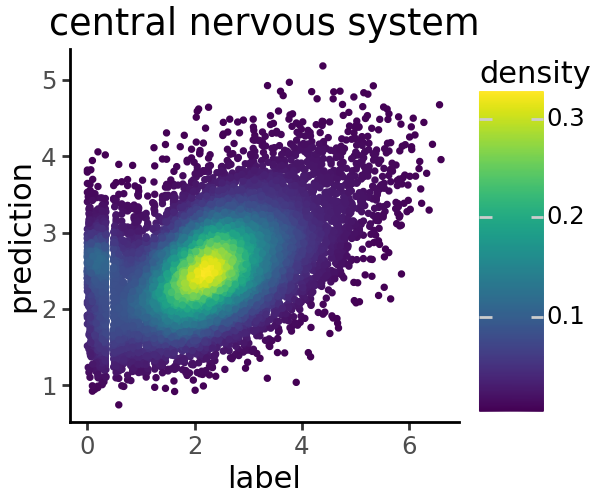

In [81]:
import plotnine as p9

fig = grelu.visualize.plot_pred_scatter(
    preds=preds,
    labels=test_dataset.get_labels(),
    tasks= [1], # neural keel is in position 10
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

fig + p9.labs(title = f'{ad.obs_names[1]}')

In [82]:
ad_test.var

,chrom,start,end
49447,chr4,1366,1866
49448,chr4,2941,3441
49449,chr4,4405,4905
49450,chr4,5949,6449
49451,chr4,12663,13163
...,...,...,...
62832,chr4,78056155,78056655
62833,chr4,78058123,78058623
62834,chr4,78083093,78083593
62835,chr4,78084337,78084837


In [83]:
preds_df[['central nervous system']].sort_values(by = "central nervous system", ascending=False)

,central nervous system
1279,5.183001
95,4.968394
3538,4.925605
3249,4.922588
10161,4.852667
...,...
8812,0.946155
9989,0.935138
8131,0.923095
1388,0.918897


In [84]:
import grelu.sequence.format

input_seqs = grelu.sequence.format.convert_input_type(
    ad_test.var,
    output_type="strings",
    genome=genome
)
input_seq = input_seqs[1279]

len(input_seq)

500

In [85]:
input_seq[:10]

'GTCATATTAT'

In [86]:
len(input_seqs)

13390

`input_seqs` contains sequences for each of the 13390 chromosomes in the test set `ad_test`.

### Forward propagation of influence using in silico mutagenesis (ISM)

In [90]:
from grelu.transforms.prediction_transforms import Aggregate

cns_peaks = Aggregate(
    tasks = ["central nervous system"],
    model = model,
)

neural_keel_peaks

Aggregate()

In [91]:
import grelu.interpret.score

In [92]:
attrs = grelu.interpret.score.get_attributions(
    model, input_seq, prediction_transform=cns_peaks, device=0,
    method="inputxgradient",
)

/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


In [88]:
'''
%%time
ism = grelu.interpret.score.ISM_predict(
    input_seq,
    model,
    genome = genome,
    prediction_transform=neural_keel_peaks, # Focus on the prediction in neural_keel_peaks
    devices=0, # Index of the GPU to use
    num_workers=8,
    return_df = True,
    compare_func="subtract",
)
'''

'\n%%time\nism = grelu.interpret.score.ISM_predict(\n    input_seq,\n    model,\n    genome = genome,\n    prediction_transform=neural_keel_peaks, # Focus on the prediction in neural_keel_peaks\n    devices=0, # Index of the GPU to use\n    num_workers=8,\n    return_df = True,\n    compare_func="subtract",\n)\n'

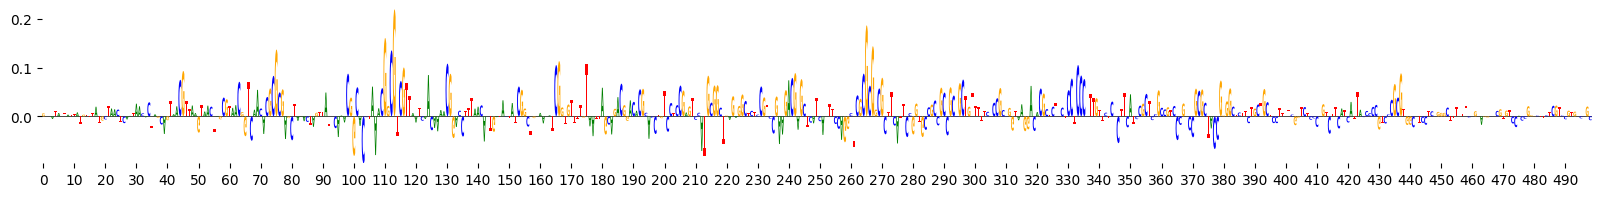

In [93]:
grelu.visualize.plot_attributions(
    attrs, 
    ticks=10,
)

In [94]:
#ism

In [95]:
'''
%matplotlib inline
grelu.visualize.plot_ISM(
    ism, method="heatmap", center=0, figsize=(20, 1.5),
)
'''

'\n%matplotlib inline\ngrelu.visualize.plot_ISM(\n    ism, method="heatmap", center=0, figsize=(20, 1.5),\n)\n'

In [96]:
'''
grelu.visualize.plot_ISM(
    ism, method='logo', figsize=(20, 1.5), highlight_positions=[99], edgecolor='red'
)
'''

"\ngrelu.visualize.plot_ISM(\n    ism, method='logo', figsize=(20, 1.5), highlight_positions=[99], edgecolor='red'\n)\n"

### From local propagation results to global interpretation

Inspecting the local file path for the `consensus` local meme file database

In [ ]:
'''import grelu.resources

grelu.resources.get_meme_file_path(meme_motif_db = 'consensus') 
'''

'/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/grelu/resources/meme/jaspar_2024_consensus.meme'

The regulatory motifs for Zebra fish (Danio Rerio) were obtained from the [`SwissRegulon Portal`](https://swissregulon.unibas.ch/data/dr11/dr11_weight_matrices) as produced by the publication:

Baranasic, D., Hörtenhuber, M., Balwierz, P.J. et al. Multiomic atlas with functional stratification and developmental dynamics of zebrafish cis-regulatory elements. Nat Genet 54, 1037–1050 (2022). https://doi.org/10.1038/s41588-022-01089-w

Furthermore, the regulatory motifs (weight matrices) was converted from its original TRANSFAC 'matrix.dat' file into a MEME motif file by using the `transfac2meme` motif conversion utility from the [`The MEME Suite`](https://web.mit.edu/meme_v4.11.4/share/doc/transfac2meme.html).



In [101]:
%%time
import grelu.interpret.modisco
grelu.interpret.modisco.run_modisco(
    model,
    seqs=ad_test.var, 
    genome=genome,
    prediction_transform=cns_peaks, # Base importance scores will be calculated with respect to this output
    meme_file="../data/danRer11.meme", # We will compare the Modisco CWMs to motifs
    method="saliency", # Base-level attribution scores will be calculated using ISM. You can also use "saliency".
    out_dir=experiment,
    batch_size=256,
    devices=0,
    num_workers=8,
    window=100, # ISM scores will be calculated over the central 100 bp of each peak
    seed=0,
)

Getting attributions


/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/grelu/interpret/score.py:172: UserWarning: hypothetical = True will be ignored as method is not deepshap.
/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


Running modisco


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [103]:
cns_peaks

Aggregate()